In [3]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import os
from transformers import (
    WhisperForConditionalGeneration,
    WhisperProcessor,
    WhisperTokenizer
)
from matplotlib.patches import Rectangle

/home/isabel.brito/.pyenv/versions/3.14.0/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
MODEL_NAME = "openai/whisper-tiny"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Sample Path and Ground Truth Text
#SAMPLE_AUDIO_PATH = "data/test_data/common_voice_en_36719.mp3" 
#SAMPLE_GT_TEXT = "When I returned to the common, the sun was setting."
#SAMPLE_AUDIO_PATH = "data/train_data/common_voice_en_38709098.mp3"
#SAMPLE_GT_TEXT = "For land, that would include such things as buildings, trees, and underground minerals."

#SAMPLE_AUDIO_PATH = "Noise.mp3"
#SAMPLE_GT_TEXT = ""


SAMPLE_AUDIO_PATH = "data/test_data/common_voice_en_37213325.mp3"
SAMPLE_GT_TEXT = "There is also the City Island Seaside Trolley run by the Bronx Tourism Council."

HEAD_ID = None

Loading openai/whisper-tiny...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: f32e7a4b-0e83-4eb8-9214-ece5b10c927c)')' thrown while requesting HEAD https://huggingface.co/openai/whisper-tiny/resolve/main/audio_tokenizer_config.json
Retrying in 1s [Retry 1/5].


Generating...


/tmp/ipykernel_17908/1364352887.py:347: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


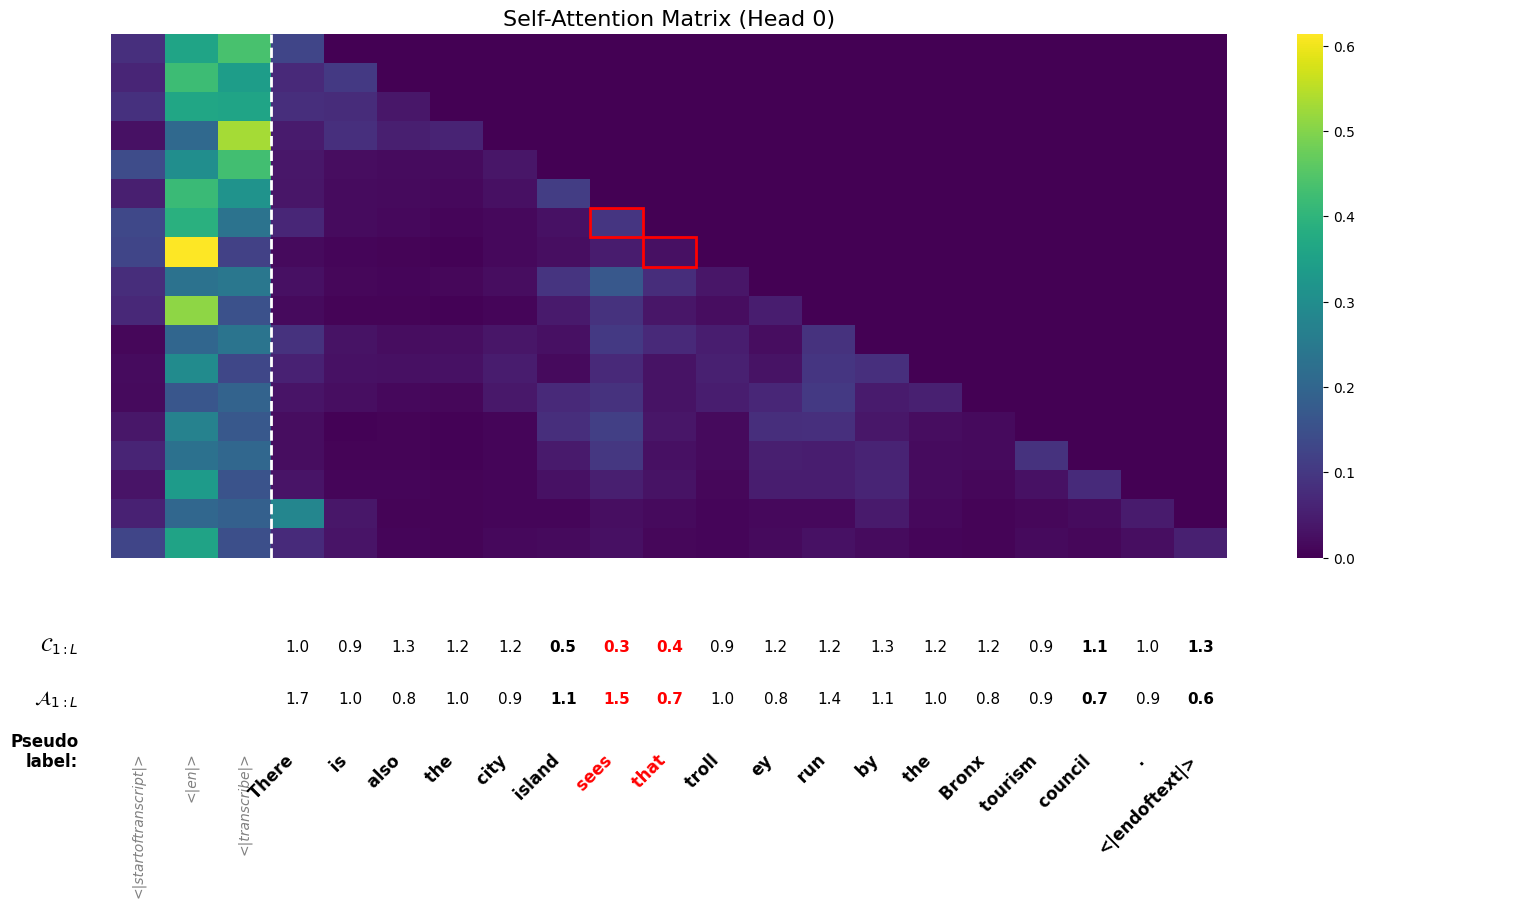

In [ ]:
def get_token_errors(token_ids, gt_text, tokenizer):
    pseudo_words = [] 
    current_word_str = ""
    current_indices = []
    
    for i, t in enumerate(token_ids):
        token_str = tokenizer.decode([t], skip_special_tokens=True)
        if token_str.startswith(" ") or i == 0:
            if current_word_str.strip():
                pseudo_words.append((current_word_str.strip(), current_indices))
            current_word_str = token_str
            current_indices = [i]
        else:
            current_word_str += token_str
            current_indices.append(i)
    if current_word_str.strip():
        pseudo_words.append((current_word_str.strip(), current_indices))

    p_strs = [w[0].lower().strip(".,?!") for w in pseudo_words]
    g_strs = [w.lower().strip(".,?!") for w in gt_text.split()]
    
    matcher = difflib.SequenceMatcher(None, p_strs, g_strs)
    
    token_is_wrong = [False] * len(token_ids)
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != 'equal':
            for word_idx in range(i1, i2):
                token_indices = pseudo_words[word_idx][1]
                for ti in token_indices:
                    token_is_wrong[ti] = True
    return token_is_wrong

def find_best_head(outputs, generated_len, prompt_len):
    """
    Scans all heads in the last layer to find the one with the strongest diagonal.
    """
    # For Whisper Tiny (4 Layers, 6 Heads)
    # Indices are 0-indexed: Layers [0, 1, 2, 3], Heads [0, 1, 2, 3, 4, 5]
   
    num_heads = outputs.decoder_attentions[0][-1].shape[1]
    best_head = 0
    max_diag_score = -1
    
    print(f"Scanning {num_heads} heads for diagonal alignment...")
    
    for h in range(num_heads):
        # Construct temporary diagonal score
        diag_sum = 0
        for t in range(generated_len):
            # Step t, Last Layer, Head h
            step_attn = outputs.decoder_attentions[t][-1][0, h] # (1, History)
            
            # The diagonal index for step t is (prompt_len + t)
            diag_idx = prompt_len + t
            
            # Safety check for index bounds
            if diag_idx < step_attn.shape[-1]:
                diag_sum += step_attn[0, diag_idx].item()
        
        if diag_sum > max_diag_score:
            max_diag_score = diag_sum
            best_head = h
            
    print(f"-> Selected Head {best_head} (Score: {max_diag_score:.2f})")
    return best_head


def analyze_sample(model, processor, audio_path, gt_text):
    model.eval()
    
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")
        
    wav, sr = torchaudio.load(audio_path)
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        wav = resampler(wav)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    wav = wav.squeeze()
    
    input_features = processor.feature_extractor(
        wav, sampling_rate=16000, return_tensors="pt"
    ).input_features.to(DEVICE)
    
    attention_mask = torch.ones(input_features.shape[0], input_features.shape[2], dtype=torch.long).to(DEVICE)

    print("Generating...")
    # NOTE: Ensure you have internet access or the model is cached!
    with torch.no_grad():
        outputs = model.generate(
            input_features,
            attention_mask=attention_mask,
            max_new_tokens=50,
            output_attentions=True,
            output_scores=True,
            return_dict_in_generate=True,
            language="en",
            task="transcribe"
        )

    pseudo_tokens = outputs.sequences[0]
    
    confidences = []
    for step_logits in outputs.scores:
        probs = torch.softmax(step_logits, dim=-1)
        top_p = probs.max().item()
        confidences.append(top_p)
    
    generated_len = len(confidences)
    first_step_attn = outputs.decoder_attentions[0][-1] 
    total_len_start = first_step_attn.shape[-1]
    prompt_len = total_len_start - 1
    total_len = prompt_len + generated_len
    
    prompt_tokens_ids = pseudo_tokens[:prompt_len]
    prompt_strs = [processor.tokenizer.decode([t]) for t in prompt_tokens_ids]

    # --- SINGLE HEAD CONFIGURATION (Tiny) ---
    # Layer 3, Head 0 is the best alignment head for Tiny
    TARGET_LAYER = 3
    TARGET_HEAD = 0

    # --- CONSTRUCT MATRIX (Step-by-Step) ---
    # We must rebuild the square matrix from the history tuples
    attn_matrix = torch.zeros((generated_len, total_len))
    
    for t in range(generated_len):
        # Access: Step t -> Layer 3 -> [Batch, Heads, Q, K]
        step_attn = outputs.decoder_attentions[t][TARGET_LAYER]
        
        # Select Batch 0, Head 0, Last Query Row [-1]
        # Shape becomes (1, Current_History_Len)
        current_row = step_attn[0, TARGET_HEAD, -1, :].cpu()
        
        # Fill the matrix row
        cur_len = current_row.shape[0]
        attn_matrix[t, :cur_len] = current_row

    # --- CALCULATE ATTENTIVE SCORES (A_l) ---
    # A_l = Row + Col - Diagonal
    # We use the reconstructed attn_matrix, not the raw tuple
    
    weights = [] # This will be our Raw A values
    for l in range(generated_len):
        col_idx = prompt_len + l
        
        # Determine start index (skip prompts roughly, but keep robust)
        start_sum_idx = max(0, prompt_len - 1)
        
        row_slice = attn_matrix[l, start_sum_idx:] 
        row_sum = row_slice.sum().item()
        col_sum = attn_matrix[:, col_idx].sum().item()
        diag = attn_matrix[l, col_idx].item()
        
        weight = row_sum + col_sum - diag
        weights.append(weight)

    # --- NORMALIZE ---
    c_mean = np.mean(confidences) if len(confidences) > 0 else 1
    # Use the calculated weights mean for normalization
    w_mean = np.mean(weights) if len(weights) > 0 else 1
    
    C_norm = [round(c / c_mean, 1) for c in confidences]
    # Normalize weights to get A_norm
    A_norm = [round(w / w_mean, 1) for w in weights]

    # --- ERRORS & TEXT ---
    gen_token_ids = pseudo_tokens[prompt_len+1:] 
    if len(gen_token_ids) != generated_len:
        gen_token_ids = pseudo_tokens[-generated_len:]

    token_strs = [processor.tokenizer.decode([t]) for t in gen_token_ids]
    is_wrong = get_token_errors(gen_token_ids, gt_text, processor.tokenizer)

    # Return the matrix for plotting, not just the single head tensor
    return attn_matrix, token_strs, C_norm, A_norm, is_wrong, prompt_strs, TARGET_HEAD

def plot_star_figure(matrix, tokens, C, A, is_wrong, prompt_strs, head_id):
    total_cols = matrix.shape[1]
    prompt_len = len(prompt_strs)
    
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[2.5, 1], hspace=0.1)
    
    ax_map = fig.add_subplot(gs[0])
    sns.heatmap(matrix, cmap="viridis", ax=ax_map, cbar=True, xticklabels=False, yticklabels=False)
    ax_map.set_title(f"Self-Attention Matrix (Head {head_id})", fontsize=16)
    
    ax_map.axvline(x=prompt_len, color='white', linewidth=2, linestyle='--')
    
    for i, wrong in enumerate(is_wrong):
        if wrong:
            rect = Rectangle((prompt_len + i, i), 1, 1, fill=False, edgecolor='red', lw=2)
            ax_map.add_patch(rect)

    ax_scores = fig.add_subplot(gs[1])
    ax_scores.set_xlim(0, total_cols)
    ax_scores.set_ylim(0, 4)
    ax_scores.axis('off')
    
    y_C, y_A, y_Tok = 3.0, 2.0, 1.0
    
    ax_scores.text(-0.5, y_C, r"$\mathcal{C}_{1:L}$", fontsize=14, fontweight='bold', va='center', ha='right')
    ax_scores.text(-0.5, y_A, r"$\mathcal{A}_{1:L}$", fontsize=14, fontweight='bold', va='center', ha='right')
    ax_scores.text(-0.5, y_Tok, "Pseudo\nlabel:", fontsize=12, fontweight='bold', va='center', ha='right')

    for i, p_str in enumerate(prompt_strs):
        if i == 0:
            x = 0.4
        else:
            x += 0.8
        ax_scores.text(x, y_Tok, p_str, ha='center', va='top', rotation=90, fontsize=10, color='gray', style='italic')

    for i, (tok, c, a, wrong) in enumerate(zip(tokens, C, A, is_wrong)):
        if i == 0:
            x = prompt_len -0.2
        else:
            x += 0.8
        color = 'red' if wrong else 'black'
        score_color = 'red' if wrong else 'black'
        fw = 'bold' if (c < 0.8 or a < 0.8) else 'normal'
        
        ax_scores.text(x, y_C, f"{c}", ha='center', va='center', color=score_color, fontweight=fw, fontsize=11)
        ax_scores.text(x, y_A, f"{a}", ha='center', va='center', color=score_color, fontweight=fw, fontsize=11)
        ax_scores.text(x, y_Tok, tok, ha='right', va='top', rotation=45, fontsize=12, color=color, fontweight='bold')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print(f"Loading {MODEL_NAME}...")
    model = WhisperForConditionalGeneration.from_pretrained(
        MODEL_NAME, attn_implementation="eager"
    ).to(DEVICE)
    processor = WhisperProcessor.from_pretrained(MODEL_NAME)
    
    try:
        matrix, tokens, C, A, errors, prompts, head = analyze_sample(
            model, processor, SAMPLE_AUDIO_PATH, SAMPLE_GT_TEXT
        )
        plot_star_figure(matrix, tokens, C, A, errors, prompts, head)
        
    except FileNotFoundError:
        print(f"File not found: {SAMPLE_AUDIO_PATH}")
    except Exception as e:
        import traceback
        traceback.print_exc()

In [26]:
import random

data = torch.load("data/star_ready/train_all.pt", weights_only=False)
random.shuffle(data)
partition = data[:1000]
torch.save(partition, "data/star_ready/partition_1000.pt")


/home/isabel.brito/.pyenv/versions/3.14.0/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading openai/whisper-tiny with eager attention...
Loading data/star_ready/partition_1000.pt...


  0%|          | 0/100 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['output_attentions', 'output_scores']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


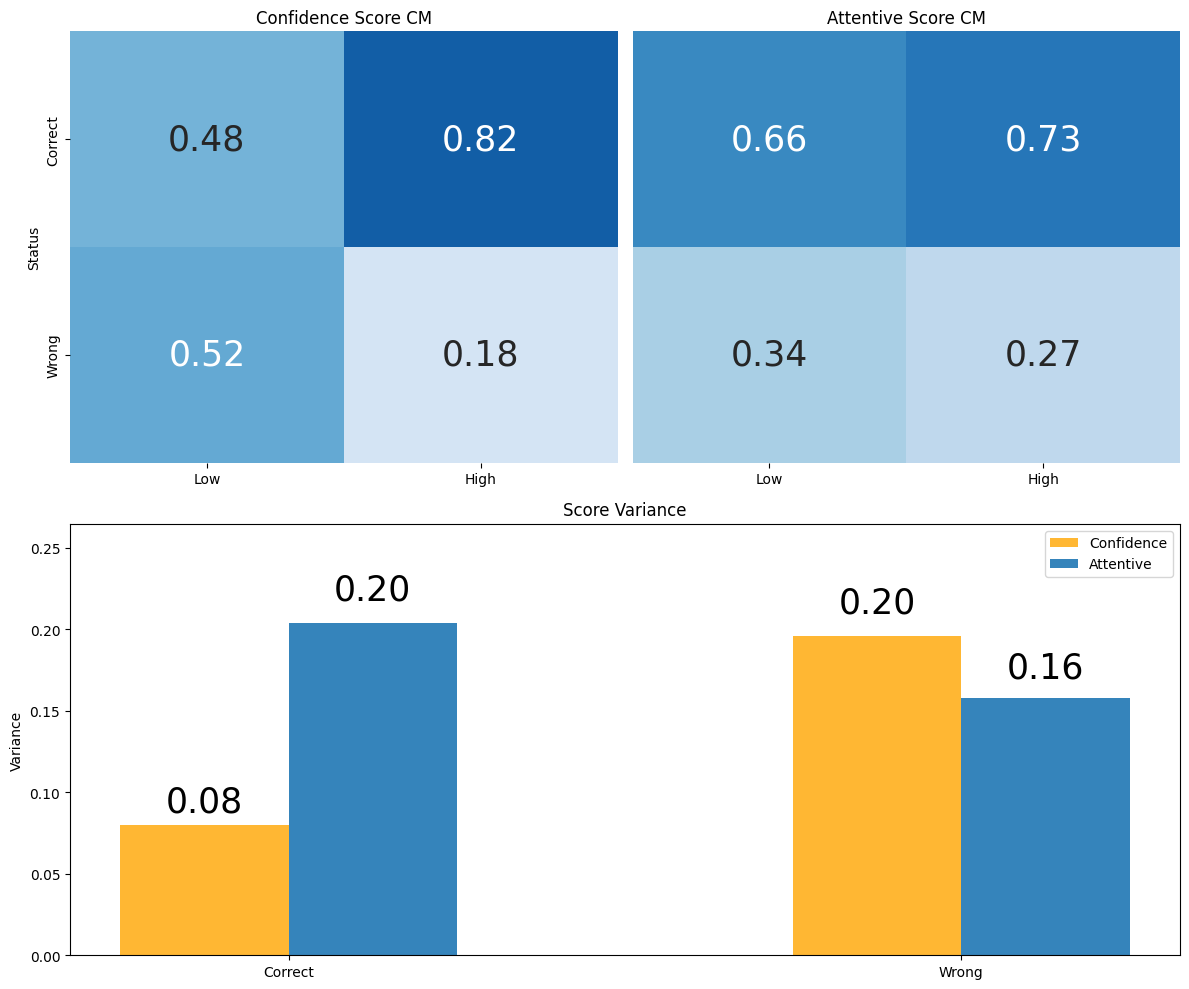

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import pandas as pd
from tqdm import tqdm
from transformers import (
    WhisperForConditionalGeneration,
    WhisperProcessor,
    WhisperTokenizer
)

# ================= CONFIGURATION =================
INPUT_PT_FILE = "data/star_ready/partition_1000.pt"
MODEL_NAME = "openai/whisper-tiny"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_SAMPLES = 100  # Number of samples to analyze
THRESHOLD = 1.0   # Paper uses 1.0 to split High/Low scores
# =================================================

def get_token_correctness(token_ids, gt_text, tokenizer):
    """
    Returns a boolean list: True if token is part of a correct word, False otherwise.
    Uses strict word-level alignment.
    """
    pseudo_words = [] 
    current_word_str = ""
    current_indices = []
    
    for i, t in enumerate(token_ids):
        token_str = tokenizer.decode([t], skip_special_tokens=True)
        if token_str.startswith(" ") or i == 0:
            if current_word_str.strip():
                pseudo_words.append((current_word_str.strip(), current_indices))
            current_word_str = token_str
            current_indices = [i]
        else:
            current_word_str += token_str
            current_indices.append(i)
    if current_word_str.strip():
        pseudo_words.append((current_word_str.strip(), current_indices))

    p_strs = [w[0].lower().strip(".,?!") for w in pseudo_words]
    
    if not gt_text: return [False] * len(token_ids)
    g_strs = [w.lower().strip(".,?!") for w in gt_text.split()]
    
    matcher = difflib.SequenceMatcher(None, p_strs, g_strs)
    
    # Default True, mark False if mismatch
    token_is_correct = [True] * len(token_ids)
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != 'equal':
            for word_idx in range(i1, i2):
                for ti in pseudo_words[word_idx][1]:
                    token_is_correct[ti] = False
                    
    return token_is_correct

def collect_stats(model, processor, dataset):
    """
    Runs inference on the dataset and collects Score vs Correctness stats.
    """
    model.eval()
    
    stats = [] 
    
    print(f"Collecting stats from {min(len(dataset), NUM_SAMPLES)} samples...")
    
    # Force decoder IDs for consistency
    forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="transcribe")
    
    for i in tqdm(range(min(len(dataset), NUM_SAMPLES))):
        item = dataset[i]
        
        # 1. Load Audio Features
        if isinstance(item['audio'], dict):
            audio_array = item['audio']['array']
            sr = item['audio'].get('sampling_rate', 16000)
        else:
            audio_array = item['audio']
            sr = 16000
            
        if isinstance(audio_array, np.ndarray):
            audio_tensor = torch.from_numpy(audio_array).float()
        else:
            audio_tensor = torch.tensor(audio_array).float()

        if sr != 16000:
             # Assuming pre-processing is done or insignificant for this check
             pass 

        input_features = processor.feature_extractor(
            audio_array, sampling_rate=16000, return_tensors="pt"
        ).input_features.to(DEVICE)
        
        attention_mask = torch.ones(input_features.shape[0], input_features.shape[2], dtype=torch.long).to(DEVICE)

        # 2. Generate
        try:
            with torch.no_grad():
                outputs = model.generate(
                    input_features,
                    attention_mask=attention_mask,
                    max_new_tokens=100,
                    output_attentions=True,
                    output_scores=True,
                    return_dict_in_generate=True,
                    forced_decoder_ids=forced_decoder_ids
                )
        except Exception as e:
            continue
            
        if outputs.scores is None or outputs.decoder_attentions is None:
            continue

        # 3. Process Scores
        confidences = []
        for s in outputs.scores:
            sm = torch.softmax(s, dim=-1)
            top_p = sm.max().item()
            confidences.append(top_p)
        
        gen_len = len(confidences)
        if gen_len == 0: continue
        
        # Determine prompt length from first step (usually 4 tokens for Whisper)
        first_step_attn = outputs.decoder_attentions[0][-1]
        total_len_start = first_step_attn.shape[-1]
        prompt_len = total_len_start - 1
        
        # Matrix Construction
        total_len = prompt_len + gen_len
        attn_matrix = torch.zeros((gen_len, total_len))
        
        for t in range(gen_len):
            step_attn = outputs.decoder_attentions[t][-1]
            
            # --- CRITICAL FIX START ---
            # Shape of step_attn: (Batch, Heads, QueryLen, KeyLen)
            # We average over heads: step_attn[0].mean(dim=0) -> (QueryLen, KeyLen)
            # We take the LAST row [-1] of the QueryLen dimension.
            # This works for QueryLen=4 (prompts) and QueryLen=1 (generation).
          
            current_row = step_attn[0, 0, -1, :].cpu()
            
            # --- CRITICAL FIX END ---

            cur_len = current_row.shape[0]
            attn_matrix[t, :cur_len] = current_row

        attentive_scores = []
        for l in range(gen_len):
            col_idx = prompt_len + l
            row_sum = attn_matrix[l, prompt_len:].sum().item()
            col_sum = attn_matrix[:, col_idx].sum().item()
            diag = attn_matrix[l, col_idx].item()
            attentive_scores.append(row_sum + col_sum - diag)

        # 4. Normalize per sample
        c_mean = np.mean(confidences) if confidences else 1
        a_mean = np.mean(attentive_scores) if attentive_scores else 1
        
        norm_conf = [c / c_mean for c in confidences]
        norm_attn = [a / a_mean for a in attentive_scores]

        # 5. Get Correctness
        gt_text = item.get('text', "")
        
        # Extract only the generated tokens (ignoring prompts)
        # outputs.sequences includes prompts, so slice off the end
        gen_token_ids = outputs.sequences[0][-gen_len:]
        
        is_correct_list = get_token_correctness(gen_token_ids, gt_text, processor.tokenizer)

        # 6. Store
        min_len = min(len(norm_conf), len(norm_attn), len(is_correct_list))
        for idx in range(min_len):
            stats.append({
                'correct': is_correct_list[idx],
                'conf': norm_conf[idx],
                'attn': norm_attn[idx]
            })
            
    return pd.DataFrame(stats)



def plot_confusion_variance(df):
    """
    Generates the Confusion Matrix and Variance plots.
    """
    # --- 1. Confusion Matrix Preparation ---
    def get_quadrant_counts(score_col):
        # Filter Correct/Wrong
        correct = df[df['correct'] == True]
        wrong = df[df['correct'] == False]
        
        c_high = len(correct[correct[score_col] > THRESHOLD])
        c_low  = len(correct[correct[score_col] <= THRESHOLD])
        
        w_high = len(wrong[wrong[score_col] > THRESHOLD])
        w_low  = len(wrong[wrong[score_col] <= THRESHOLD])
        
        # Normalize columns (Probability of Correct/Wrong given High/Low)
        total_low = c_low + w_low + 1e-6
        total_high = c_high + w_high + 1e-6
        
        return np.array([
            [c_low/total_low, c_high/total_high],
            [w_low/total_low, w_high/total_high]
        ])

    conf_matrix_data = get_quadrant_counts('conf')
    attn_matrix_data = get_quadrant_counts('attn')

    # --- 2. Variance Preparation ---
    var_df = df.groupby('correct')[['conf', 'attn']].var().reset_index()
    # Handle missing categories
    for val in [True, False]:
        if val not in var_df['correct'].values:
            empty = pd.DataFrame({'correct': [val], 'conf': [0], 'attn': [0]})
            var_df = pd.concat([var_df, empty], ignore_index=True)
            
    c_row = var_df[var_df['correct'] == True]
    w_row = var_df[var_df['correct'] == False]
    
    var_c_correct = c_row['conf'].values[0] if not c_row.empty else 0
    var_c_wrong   = w_row['conf'].values[0]   if not w_row.empty else 0
    var_a_correct = c_row['attn'].values[0] if not c_row.empty else 0
    var_a_wrong   = w_row['attn'].values[0]   if not w_row.empty else 0

    # --- PLOTTING ---
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

    # Plot 1: Confidence CM
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(conf_matrix_data, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=["Low", "High"], yticklabels=["Correct", "Wrong"], ax=ax1, vmin=0, vmax=1, cbar=False,  annot_kws={"size": 25})
    ax1.set_title("Confidence Score CM")
    ax1.set_ylabel("Status")
    
    # Plot 2: Attentive CM
    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(attn_matrix_data, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=["Low", "High"], yticklabels=["Correct", "Wrong"], ax=ax2, vmin=0, vmax=1, annot_kws={"size": 25}, cbar=False)
    ax2.set_title("Attentive Score CM")
    ax2.set_yticks([]) 

    # Plot 3: Variance
    ax3 = fig.add_subplot(gs[1, :])
    labels = ['Correct', 'Wrong']
    x = np.arange(len(labels))
    width = 0.25
    
    bars1 = ax3.bar(x - width/2, [var_c_correct, var_c_wrong], width, label='Confidence', color='orange', alpha=0.8)
    bars2 = ax3.bar(x + width/2, [var_a_correct, var_a_wrong], width, label='Attentive', color='#1f77b4', alpha=0.9)
    
    for bar in bars1 + bars2:
        h = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., 1.05*h, f'{h:.2f}', ha='center', va='bottom', fontsize=25)

    ax3.set_ylabel('Variance')
    ax3.set_title('Score Variance')
    ax3.set_xticks(x)
    ax3.set_xticklabels(labels)
    ax3.legend()
    # Add buffer to top of plot
    max_h = max(var_c_wrong, var_a_wrong, var_a_correct, var_c_correct)
    ax3.set_ylim(0, max_h * 1.3 if max_h > 0 else 1.0)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print(f"Loading {MODEL_NAME} with eager attention...")
    model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME, attn_implementation="eager").to(DEVICE)
    processor = WhisperProcessor.from_pretrained(MODEL_NAME)
    
    print(f"Loading {INPUT_PT_FILE}...")
    try:
        dataset = torch.load(INPUT_PT_FILE, weights_only=False)
        if len(dataset) == 0:
            print("Dataset empty.")
        else:
            df_stats = collect_stats(model, processor, dataset)
            if not df_stats.empty:
                plot_confusion_variance(df_stats)
            else:
                print("No stats collected.")
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"Error: {e}")